In [164]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import time


#define plotting style that I like
style.use('fivethirtyeight')

#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

#define runtime calculator
def timer(elapsed_time):
    seconds = (time.time() - elapsed_time)
    day = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    seconds = seconds
    print('')
    print('Total cell runtime:', "%s days, %s hours, %s minutes, %s seconds" % (day, hour, minutes, seconds) )
    print('')
    
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)

def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

def train_and_plot(rxn_observable, reac_observ):
    #start timer
    rxn_observable_time = time.time()
    # One-hot encode categorical features
    rxn_observable_plot = pd.get_dummies(rxn_observable)
    # Labels are the values we want to predict
    labels = np.array(rxn_observable_plot['K_experimental_value'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features = rxn_observable_plot.drop('K_experimental_value', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    rxn_observable_test_mean=np.zeros(intervals) 
    rxn_observable_train_mean=np.zeros(intervals) 
    rxn_observable_test_variance=np.zeros(intervals) 
    rxn_observable_train_variance=np.zeros(intervals) 
    for i in range(intervals): 
        #define size
        size=(i+1)/(intervals+1)
        #call split function
        test, test_v, train, train_v = split_and_score(size, number_of_random_states)
        #add to arrays
        rxn_observable_test_mean[i]=test
        rxn_observable_train_mean[i]=train
        rxn_observable_test_variance[i]=test_v
        rxn_observable_train_variance[i]=train_v
    print("Average Testing Score:", rxn_observable_test_mean)
    print('Testing Variance', rxn_observable_test_variance)
    print('')
    print('Average Training Score', rxn_observable_train_mean)
    print('Training Variance', rxn_observable_train_variance)
    print('')

    #plot 

    #figure
    figure(figsize=(15, 5))
    ax=plt.subplot(111)
    plt.xlabel('Test Size (%)')
    plt.ylabel('Score')
    plt.title("Reaction_Observable: {}".format(reac_observ))
    plt.xlim(left=0, right=100)
    ax.scatter(sample_size, rxn_observable_test_mean, s=100, label='Average Testing Score')
    ax.scatter(sample_size, rxn_observable_train_mean, s=100, label='Average Training Score')
    ax.errorbar(sample_size, rxn_observable_test_mean, yerr=rxn_observable_test_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.errorbar(sample_size, rxn_observable_train_mean, yerr=rxn_observable_train_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.legend(loc='best')
    plt.show

    #print elapsed time
    timer(rxn_observable_time)

In [165]:
def new_phenom_rename(df, observable):
    df.rename(columns={'t_lab':'energy'}, inplace=True)
    df.rename(columns={'observable':'experimental_value'}, inplace=True)
    df.rename(columns={'error':'sigma'}, inplace=True)
    df['observable']=observable
    
def combine_data_new():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #new phenomenological data
    sgt_small= pd.read_csv('CSV_files/sgt_0_75.csv')
    sgtt_small=pd.read_csv('CSV_files/sgtt_0_75.csv')
    sgt_large=pd.read_csv('CSV_files/sgt_75_350.csv')
    sgtt_large=pd.read_csv('CSV_files/sgtt_75_350.csv')
    new_phenom_rename(sgt_small,'   SGT ')
    new_phenom_rename(sgtt_small,'   SGTT')
    new_phenom_rename(sgt_large,'   SGT ')
    new_phenom_rename(sgtt_large,'   SGTT')
    new_data = pd.concat([sgt_small, sgt_large, sgtt_small, sgtt_large])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data, new_data], sort=True)
    #combined_data = pd.concat([random_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def combine_data_old():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data], sort=True)
    #combined_data = pd.concat([random_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def gauss_factor(combined_data, mu, sigma):
    ###create Gaussian factor 
    #Gaussian distribution
    combined_data['Gauss_factor'] = np.random.normal(mu, sigma, len(combined_data.energy))
    combined_data['Gauss_exp'] = combined_data.apply(lambda row: ((row.K_experimental_value) + (row.K_sigma*row.Gauss_factor)), axis=1)
    #remove unecessary columns
    combined_data = combined_data.drop(columns=['K_experimental_value', 'K_sigma', 'experimental_value', 'k', 'sigma', 'Gauss_factor'])
    return combined_data

Text(0.5, 1.0, 'Neutron-Proton $\\Delta \\sigma_T$')

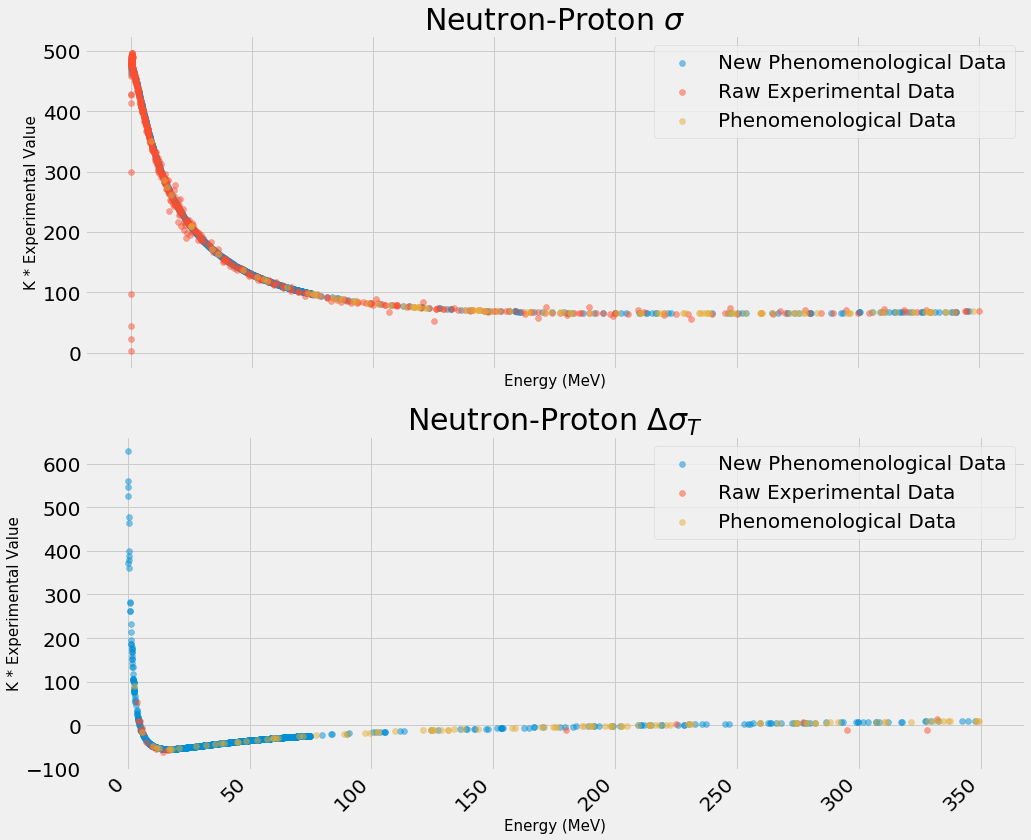

In [166]:
#organize experimental and phenomenological data for plotting
#read files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
random_sgt=pd.read_csv('CSV_files/random.sgt.csv')
random_sgtt=pd.read_csv('CSV_files/random.sgtt.csv')
sgt_small= pd.read_csv('CSV_files/sgt_0_75.csv')
sgtt_small=pd.read_csv('CSV_files/sgtt_0_75.csv')
sgt_large=pd.read_csv('CSV_files/sgt_75_350.csv')
sgtt_large=pd.read_csv('CSV_files/sgtt_75_350.csv')

new_phenom_rename(sgt_small,'   SGT ')
new_phenom_rename(sgtt_small,'   SGTT')
new_phenom_rename(sgt_large,'   SGT ')
new_phenom_rename(sgtt_large,'   SGTT')

new_sgt = pd.concat([sgt_small, sgt_large], sort=True)
new_sgtt = pd.concat([sgtt_small, sgtt_large], sort=True)
#add k columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)
change_np(random_sgt)
change_np(random_sgtt)
change_np(new_sgt)
change_np(new_sgtt)
#error bar arrays
rand_err_sgt=random_sgt['K_sigma'].tolist()
rand_err_sgtt=random_sgtt['K_sigma'].tolist()
exp_err_sgt=np_sgt['K_sigma'].tolist()
exp_err_sgtt=np_sgtt['K_sigma'].tolist()
new_err_sgt=new_sgt['K_sigma'].tolist()
new_err_sgtt=new_sgtt['K_sigma'].tolist()


#plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)

###plot 1

ax1.scatter(new_sgt['energy'], new_sgt['K_experimental_value'], alpha=0.5, label='New Phenomenological Data')
#ax1.errorbar(new_sgt['energy'], new_sgt['K_experimental_value'], yerr=new_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='New Phenomenological Error')

ax1.scatter(np_sgt['energy'], np_sgt['K_experimental_value'], alpha=0.5, label='Raw Experimental Data')
#ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')

ax1.scatter(random_sgt['energy'], random_sgt['K_experimental_value'], alpha=0.5, label='Phenomenological Data')
#ax1.errorbar(random_sgt['energy'], random_sgt['K_experimental_value'], yerr=rand_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=15); ax1.set_ylabel('K * Experimental Value', fontsize=15)
ax1.legend(loc='best', fontsize=20); ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)

###plot 2

ax2.scatter(new_sgtt['energy'], new_sgtt['K_experimental_value'], alpha=0.5, label='New Phenomenological Data')
#ax2.errorbar(new_sgtt['energy'], new_sgtt['K_experimental_value'], yerr=new_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='New Phenomenological Error')

ax2.scatter(np_sgtt['energy'], np_sgtt['K_experimental_value'], alpha=0.5, label='Raw Experimental Data')
#ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')

ax2.scatter(random_sgtt['energy'], random_sgtt['K_experimental_value'], alpha=0.5, label='Phenomenological Data')
#ax2.errorbar(random_sgtt['energy'], random_sgtt['K_experimental_value'], yerr=rand_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=15); ax2.set_ylabel('K * Experimental Value', fontsize=15)
ax2.legend(loc='best', fontsize=20); ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)

In [167]:
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
###  PARAMETERS TO BE CHANGED ARE ALL IN THIS CELL  ###
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################

#define number of times to make predictions with different gaussian factor
n_max=25

#define interval step size for predictions 
###MUST BE INTEGER >=1 AND FACTOR OF 350
interval_size = 10 #MeV  

#define number of trees used in random forest 
num_trees=1000

#define test size
test_data_size = 0.25 # % of total amount of data

Predictions computed with n = 1 
Predictions computed with n = 2 
Predictions computed with n = 3 
Predictions computed with n = 4 
Predictions computed with n = 5 
Predictions computed with n = 6 
Predictions computed with n = 7 
Predictions computed with n = 8 
Predictions computed with n = 9 
Predictions computed with n = 10 
Predictions computed with n = 11 
Predictions computed with n = 12 
Predictions computed with n = 13 
Predictions computed with n = 14 
Predictions computed with n = 15 
Predictions computed with n = 16 
Predictions computed with n = 17 
Predictions computed with n = 18 
Predictions computed with n = 19 
Predictions computed with n = 20 
Predictions computed with n = 21 
Predictions computed with n = 22 
Predictions computed with n = 23 
Predictions computed with n = 24 
Predictions computed with n = 25 

Total cell runtime: 0.0 days, 0.0 hours, 1.0 minutes, 46.56418514251709 seconds



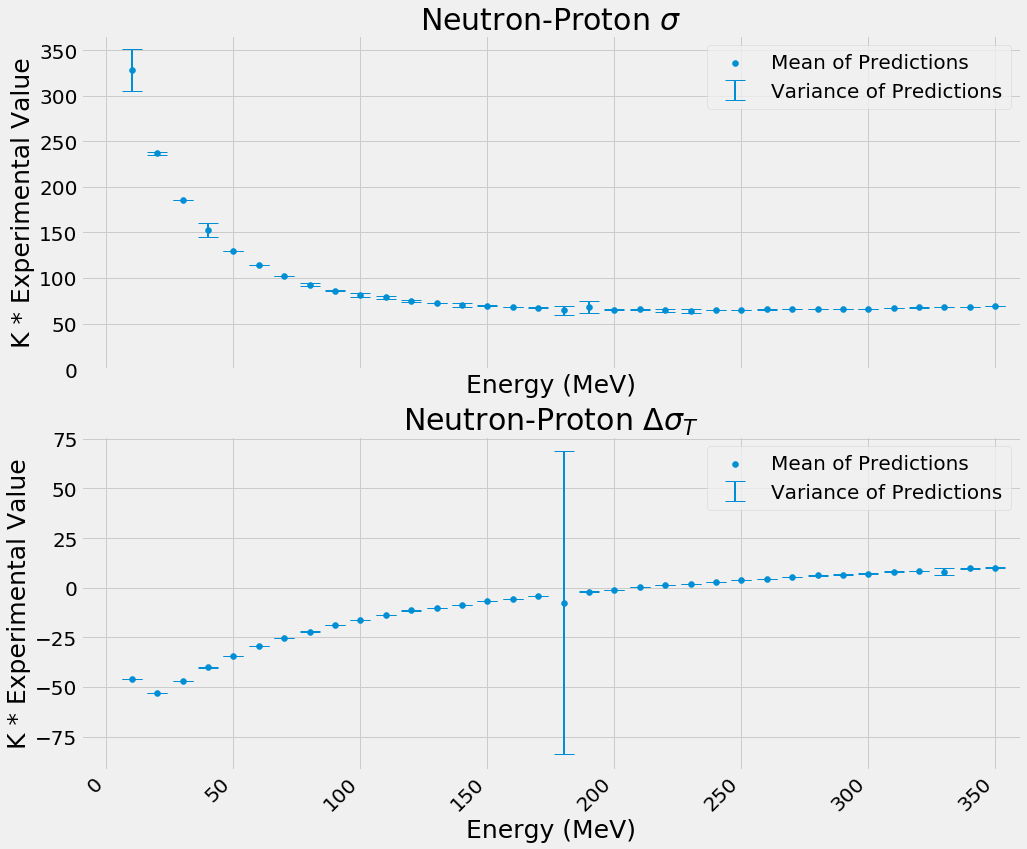

In [168]:
#start timer
gauss_time=time.time()

#define interval specifications for prediction arrays
E_max=350
num_intervals = E_max/interval_size
E_index = list(range(interval_size, E_max + int(interval_size), interval_size)) ###this will be index of dataframe

df_SGT=pd.DataFrame({'Energy': E_index})
df_SGTT=pd.DataFrame({'Energy': E_index})


for n in range(1,n_max+1):
    ###create combined dataframe
    combined_data=combine_data_new()
    #combined_data=combine_data_old()
    ###create Gaussian factor 
    combined_data=gauss_factor(combined_data, 0, 1)

    ###train
    #One-hot encode
    features = pd.get_dummies(combined_data)
    # Labels are the values we want to predict
    labels = np.array(features['Gauss_exp'])
    # Remove the labels from the features
    features = features.drop('Gauss_exp', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_data_size)
    rf = RandomForestRegressor(n_estimators= num_trees)
    # Train the model on training data
    rf.fit(train_features, train_labels);

    ###make predictions 
    #construct testing arrays
    E_SGT = []
    E_SGTT = []
    E = list(range(interval_size, E_max + int(interval_size), interval_size))
    for value in E:
        E_SGT.append([value, 1, 0])
        E_SGTT.append([value, 0, 1])
    #predict
    #SGT
    SGT_predictions = rf.predict(E_SGT)
    #SGTT
    SGTT_predictions = rf.predict(E_SGTT)
    
    #add column to dataframes
    df_SGT["SGT_Preds_%s"%('%.0f'%n)] = SGT_predictions
    df_SGTT["SGTT_Preds_%s"%('%.0f'%n)] = SGTT_predictions
    
    #print completed message
    print("Predictions computed with n = %s "%('%.0f'%n))

#predictions array     
df_SGT = df_SGT.drop("Energy", axis=1)
df_SGT['Prediction Mean'] = df_SGT.mean(axis=1)
df_SGT['Prediction Variance'] = df_SGT.var(axis=1)
df_SGTT = df_SGTT.drop("Energy", axis=1)
df_SGTT['Prediction Mean'] = df_SGTT.mean(axis=1)
df_SGTT['Prediction Variance'] = df_SGTT.var(axis=1)

df_SGT.head(4)

#plot 
#figure specs
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)

#plot 1 - SGT
ax1.scatter(E, df_SGT['Prediction Mean'], label='Mean of Predictions')
ax1.errorbar(E, df_SGT['Prediction Mean'], yerr=df_SGT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')
#ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
#ax1.plot(random_sgt['energy'], random_sgt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
#ax1.errorbar(random_sgt['energy'], random_sgt['K_experimental_value'], yerr=rand_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=25)
ax1.set_xlim([-10,360])
ax1.set_ylim(bottom=0)
ax1.set_ylabel('K * Experimental Value', fontsize=25)
ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)

#plot 2 - SGTT
ax2.scatter(E, df_SGTT['Prediction Mean'], label='Mean of Predictions')
ax2.errorbar(E, df_SGTT['Prediction Mean'], yerr=df_SGTT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')
#ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
#ax2.plot(random_sgtt['energy'], random_sgtt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
#ax2.errorbar(random_sgtt['energy'], random_sgtt['K_experimental_value'], yerr=rand_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax2.tick_params(axis="y", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=25)
ax2.set_xlim([-10,360])
ax2.set_ylabel('K * Experimental Value', fontsize=25)
ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)

#save figures
plt.savefig('Plots/predictions_with_gauss.pdf', format='pdf', bboxinches='tight', transparent=True)

#print elapsed time
timer(gauss_time)

In [169]:
df_SGT['Energy']=E
df_SGT.set_index("Energy", inplace = True)
df_SGT

,SGT_Preds_1,SGT_Preds_2,SGT_Preds_3,SGT_Preds_4,SGT_Preds_5,SGT_Preds_6,SGT_Preds_7,SGT_Preds_8,SGT_Preds_9,SGT_Preds_10,...,SGT_Preds_18,SGT_Preds_19,SGT_Preds_20,SGT_Preds_21,SGT_Preds_22,SGT_Preds_23,SGT_Preds_24,SGT_Preds_25,Prediction Mean,Prediction Variance
Energy,,,,,,,,,,,,,,,,,,,,,
10,328.058810,326.477709,325.317008,325.746247,336.082932,325.873032,331.082557,328.914912,331.489874,332.680630,...,327.606143,323.955927,325.100387,330.612770,327.373998,331.006227,337.404789,329.800419,328.806219,23.078304
20,237.206715,238.306195,236.373970,238.322997,234.674475,238.276187,238.490546,234.899029,235.562885,238.027099,...,233.074522,234.012289,237.795550,236.396368,236.700575,237.315621,237.871879,237.158792,236.720660,1.921238
30,185.505304,185.482111,185.389183,185.553856,185.516712,185.487657,185.612348,185.609667,185.408009,185.572917,...,185.534257,185.668491,185.638029,185.515216,185.292923,185.588912,185.437346,185.476090,185.497252,0.009484
40,151.332351,154.949281,153.032704,155.190537,152.362185,151.503086,154.871364,150.537739,154.159335,156.023260,...,153.192317,145.933885,153.946877,149.260658,152.431597,152.410989,153.070102,154.997670,152.927229,7.813362
50,130.063708,129.890356,129.827501,129.994253,129.892256,129.822548,129.815705,129.802693,129.862908,129.980637,...,129.976613,129.891965,130.038129,129.970748,129.850026,129.866513,129.828436,130.004710,129.899311,0.008724
60,114.017674,113.536395,113.950117,114.812804,113.741552,114.039047,113.877245,113.660520,113.844660,113.630418,...,114.160969,115.068154,113.882441,114.338592,113.644368,113.887395,113.755588,113.993797,114.010996,0.126431
70,102.414615,102.395328,102.307542,102.235545,102.307104,102.272883,102.280045,102.089624,102.346876,102.391993,...,102.402014,102.374893,102.237783,102.321889,102.351544,102.394410,102.274406,102.307884,102.317534,0.005930
80,91.405089,93.518181,91.945717,92.182754,93.260102,94.876542,90.959262,93.479688,92.376604,92.342088,...,91.793780,95.492335,92.344733,96.141058,93.122409,93.162642,91.203242,92.083855,92.699775,1.996018
90,86.071010,86.488821,86.145579,85.203214,86.709581,86.263061,86.199331,86.478876,86.190314,86.512227,...,85.737448,86.481956,86.856088,86.234547,86.292055,84.151998,86.331591,86.443577,86.176176,0.344153


In [170]:
df_SGTT['Energy']=E
df_SGTT.set_index("Energy", inplace = True)
df_SGTT

,SGTT_Preds_1,SGTT_Preds_2,SGTT_Preds_3,SGTT_Preds_4,SGTT_Preds_5,SGTT_Preds_6,SGTT_Preds_7,SGTT_Preds_8,SGTT_Preds_9,SGTT_Preds_10,...,SGTT_Preds_18,SGTT_Preds_19,SGTT_Preds_20,SGTT_Preds_21,SGTT_Preds_22,SGTT_Preds_23,SGTT_Preds_24,SGTT_Preds_25,Prediction Mean,Prediction Variance
Energy,,,,,,,,,,,,,,,,,,,,,
10,-45.804869,-46.102218,-45.719889,-45.810630,-45.953119,-45.770208,-46.005684,-45.952646,-45.846431,-45.853837,...,-45.796456,-46.125884,-45.875311,-45.934024,-45.608421,-45.814179,-45.961283,-45.997151,-45.907343,0.016898
20,-53.028073,-53.253468,-53.006429,-53.369241,-53.320534,-53.320469,-53.517858,-52.914334,-53.151418,-53.169536,...,-53.137690,-53.184505,-53.122476,-52.910954,-53.065199,-52.869613,-53.148212,-53.154879,-53.150817,0.033864
30,-46.906364,-47.205951,-47.154457,-46.753547,-47.035955,-46.809587,-46.963203,-46.977433,-47.097285,-46.943101,...,-47.058453,-47.238103,-47.064896,-47.225477,-47.032022,-46.752970,-46.842705,-47.015640,-47.009863,0.018525
40,-40.044831,-40.544555,-40.272013,-40.095341,-40.027051,-40.297743,-40.074403,-40.447480,-40.145337,-39.976507,...,-40.164292,-40.060892,-40.414276,-40.015710,-40.272763,-40.219560,-40.401462,-40.289092,-40.213880,0.034453
50,-34.432639,-34.318512,-34.509178,-34.592013,-34.642136,-34.351014,-34.376265,-34.866416,-34.503754,-34.202364,...,-34.360805,-34.480290,-34.369179,-34.629027,-34.289239,-34.235115,-34.375866,-34.242176,-34.436004,0.022641
60,-29.473170,-29.418710,-29.467428,-29.612448,-29.393374,-29.532433,-29.628449,-29.450321,-29.746393,-29.250246,...,-29.347383,-29.475682,-29.549057,-29.762296,-29.642101,-29.695076,-29.634875,-29.510441,-29.515226,0.017458
70,-25.538036,-25.429859,-25.415408,-25.383895,-25.371192,-25.438901,-25.238865,-25.395326,-25.352705,-25.367453,...,-25.323244,-25.324804,-25.693467,-25.293661,-25.479701,-25.367262,-25.411857,-25.414207,-25.414194,0.009655
80,-21.896950,-21.911284,-22.203563,-21.434074,-22.013218,-21.937981,-21.712161,-21.805214,-22.337900,-21.888263,...,-22.674136,-22.125580,-22.757384,-22.282582,-23.132483,-22.238820,-21.999899,-22.108208,-22.143400,0.120059
90,-19.135826,-18.847708,-18.797044,-18.893745,-19.332188,-18.867503,-18.973776,-19.016571,-18.921647,-18.982241,...,-18.834125,-19.066159,-18.696771,-18.777348,-18.876379,-18.938065,-19.100882,-18.919841,-18.958515,0.028679
